# Layer wise learning rate settings

In this tutorial, we introduce how to easily select or filter out network layers and set specific learning rate values for transfer learning.    
MONAI provides a utility function to achieve this requirements: `generate_param_groups`, for example:
```py
net = Unet(dimensions=3, in_channels=1, out_channels=3, channels=[2, 2, 2], strides=[1, 1, 1])
print(net)  # print out network components to select expected items
print(net.named_parameters())  # print out all the named parameters to filter out expected items
params = generate_param_groups(
    network=net,
    layer_matches=[lambda x: x.model[-1], lambda x: "conv.weight" in x],
    match_types=["select", "filter"],
    lr_values=[1e-2, 1e-3],
)
optimizer = torch.optim.Adam(params, 1e-4)
```
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/layer_wise_learning_rate.ipynb)

## Setup environment

In [1]:
%pip install -q "monai[pillow, ignite, tqdm]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import shutil
import sys
import tempfile

from ignite.metrics import Accuracy
from ignite.engine import Engine, Events
import matplotlib.pyplot as plt
import torch

from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.engines import SupervisedTrainer
from monai.handlers import StatsHandler
from monai.inferers import SimpleInferer
from monai.networks.nets import densenet121
from monai.optimizers import generate_param_groups
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
)

print_config()

MONAI version: 0.4.0
Numpy version: 1.19.1
Pytorch version: 1.7.0a0+7036e91
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.2.0
gdown version: 3.12.2
TorchVision version: 0.8.0a0
ITK version: 5.1.0
tqdm version: 4.54.1
lmdb version: 1.0.0
psutil version: 5.7.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Setup logging

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Create training experiment with MedNISTDataset and workflow

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

### Set up pre-processing transforms

In [4]:
transform = Compose(
    [
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        ToTensord(keys="image"),
    ]
)

### Create MedNISTDataset for training
`MedNISTDataset` inherits from MONAI `CacheDataset` and provides rich parameters to automatically download dataset and extract, and acts as normal PyTorch Dataset with cache mechanism.

In [5]:
train_ds = MedNISTDataset(root_dir=root_dir, transform=transform, section="training", download=True)
# the dataset can work seamlessly with the pytorch native dataset loader,
# but using monai.data.DataLoader has additional benefits of mutli-process
# random seeds handling, and the customized collate functions
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /workspace/data/medical/MedNIST.tar.gz exists, skip downloading.
extracted file /workspace/data/medical/MedNIST exists, skip extracting.


100%|██████████| 46946/46946 [01:21<00:00, 579.02it/s]


### Pick images from MedNISTDataset to visualize and check

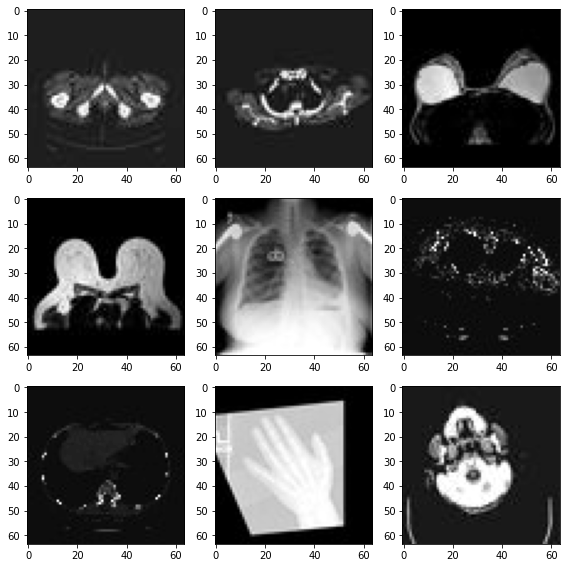

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_ds[i * 5000]["image"][0].detach().cpu(), cmap="gray")
plt.tight_layout()
plt.show()

### Create training components - device, network, loss function

In [8]:
device = torch.device("cuda:0")
net = densenet121(pretrained=True, progress=False, spatial_dims=2, in_channels=1, out_channels=6).to(device)
loss = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


### Set different learning rate values for layers
Please refer to the appendix at the end this notebook for the layers of `DenseNet121`.
1. Set LR=1e-3 for the selected `class_layers` block.
2. Set LR=1e-4 for convolution layers based on the filter where `conv.weight` is in the layer name.
3. LR=1e-5 for other layers.

In [9]:
params = generate_param_groups(
    network=net,
    layer_matches=[lambda x: x.class_layers, lambda x: "conv.weight" in x],
    match_types=["select", "filter"],
    lr_values=[1e-3, 1e-4],
)

### Define the optimizer based on the parameter groups

In [10]:
opt = torch.optim.Adam(params, 1e-5)

### Define the easiest training workflow and run

Use MONAI SupervisedTrainer handlers to quickly set up a training workflow.

In [11]:
trainer = SupervisedTrainer(
    device=device,
    max_epochs=5,
    train_data_loader=train_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    inferer=SimpleInferer(),
    key_train_metric={
        "train_acc": Accuracy(output_transform=lambda x: (x["pred"], x["label"]))
    },
    train_handlers=StatsHandler(tag_name="train_loss", output_transform=lambda x: x["loss"]),
)

### Define a ignite handler to adjust LR in runtime

In [12]:
class LrScheduler:
    def attach(self, engine: Engine) -> None:
        engine.add_event_handler(Events.EPOCH_COMPLETED, self)

    def __call__(self, engine: Engine) -> None:
        for i, param_group in enumerate(engine.optimizer.param_groups):
            if i == 0:
                param_group["lr"] *= 0.1
            elif i == 1:
                param_group["lr"] *= 0.5
        
        print("LR values of 3 parameter groups: ", [g["lr"] for g in engine.optimizer.param_groups])

LrScheduler().attach(trainer)

### Execute the training

In [ ]:
trainer.run()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)

## Appendix: layers of DenseNet 121 network

In [14]:
print(net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm